<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_03_auto_ml_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Validation

In [ ]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2'

In [2]:
if COLAB:
  # !sudo apt-get install git-lfs && git lfs install
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  #!cd dl-projects && ls -l --block-size=M

Cloning into 'dl-projects'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 831 (delta 29), reused 2 (delta 1), pack-reused 781
Receiving objects: 100% (831/831), 68.80 MiB | 24.52 MiB/s, done.
Resolving deltas: 100% (477/477), done.


In [ ]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .

In [ ]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib
import sys

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, mean_squared_error, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.ensemble import RandomForestClassifier
#from scikitplot.plotters import plot_precision_recall_curve
from dateutil.relativedelta import relativedelta

from IPython.display import display

from utils import *
from preprocess import *

np.set_printoptions(threshold=sys.maxsize)

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [6]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [7]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.pkl"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 3954M
-rw------- 1 root root  407M Dec 30 05:00 feature_matrix_2.csv
-rw------- 1 root root  428M Dec 30 05:01 feature_matrix_2.pkl
-rw------- 1 root root  141M Dec 27 08:27 feature_matrix.csv
-rw------- 1 root root 1637M Jan  4 07:31 feature_matrix_d2.csv
-rw------- 1 root root 1166M Jan  4 07:35 feature_matrix_d2.pkl
-rw------- 1 root root  176M Dec 27 08:28 feature_matrix.pkl
total 1M
-rw-r--r-- 1 root root 1M Jan  4 15:49 4D.zip


In [ ]:
#data = pd.read_csv(DATASET, header=0, sep=',', quotechar='"', parse_dates=['time'])
#data = pd.read_csv(DATASET_PATH/"feature_matrix_2.csv", header=0, sep=',', quotechar='"', parse_dates=['time'])
data = pd.read_pickle(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719972 entries, 0 to 719971
Columns: 221 entries, NumberId to year
dtypes: datetime64[ns](1), float64(146), int64(64), uint8(10)
memory usage: 1.1 GB


## Exploratory Data Analysis

In [ ]:
feature_matrix = data

In [12]:
display(feature_matrix.columns)

Index(['NumberId', 'time', 'STD(Results.DrawNo)', 'STD(Results.LuckyNo)',
       'STD(Results.TotalStrike)', 'MAX(Results.DrawNo)',
       'MAX(Results.LuckyNo)', 'MAX(Results.TotalStrike)',
       'MIN(Results.DrawNo)', 'MIN(Results.LuckyNo)',
       ...
       'MODE(Results.PrizeType)_3rdPrizeNo',
       'MODE(Results.PrizeType)_Consolation',
       'MODE(Results.PrizeType)_Special', 'LAST(Results.PrizeType)_1stPrizeNo',
       'LAST(Results.PrizeType)_2ndPrizeNo',
       'LAST(Results.PrizeType)_3rdPrizeNo',
       'LAST(Results.PrizeType)_Consolation',
       'LAST(Results.PrizeType)_Special', 'month', 'year'],
      dtype='object', length=221)

In [83]:
display(feature_matrix.head(4).T)

,0,1,2,3
index,0,1,2,3
NumberId,0,1,2,3
time,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00
STD(Results.DrawNo),116257,96697.5,49525.7,116135
STD(Results.LuckyNo),0,0,0,0
...,...,...,...,...
LAST(Results.PrizeType)_SpecialNo7,0,0,0,0
LAST(Results.PrizeType)_SpecialNo8,0,0,0,0
LAST(Results.PrizeType)_SpecialNo9,1,0,0,0
month,1,1,1,1


In [14]:
origin_data[origin_data['LuckyNo']==911].head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo
10287,85495,1995-03-12,ConsolationNo3,911
13607,99896,1996-02-11,SpecialNo10,911
26564,156199,1999-08-29,SpecialNo9,911
30160,171800,2000-08-16,ConsolationNo4,911
65817,326909,2009-12-05,SpecialNo10,911
89716,430815,2015-10-07,SpecialNo3,911
96458,460117,2017-05-27,SpecialNo6,911
102733,487418,2018-12-08,SpecialNo2,911
104575,495419,2019-06-01,SpecialNo4,911
104910,496919,2019-07-03,ConsolationNo4,911


In [ ]:
# feature_matrix.groupby('time')['COUNT(Results)'].mean().plot()
# plt.title('Average Monthly Count of Results')
# plt.ylabel('Strike Per Number')

## Feature Selection

In [16]:
from utils import feature_selection

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'NumberId']))

Original shape:  (719972, 219)
0 missing columns with threshold: 90.
42 zero variance columns.
115 collinear columns removed with threshold: 0.95.
Total columns removed:  157
Shape after feature selection: (719972, 62).


In [ ]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['NumberId'] = feature_matrix['NumberId']
feature_matrix_selection['Label'] = feature_matrix['Label']

In [39]:
len(feature_matrix_selection.columns), feature_matrix_selection.columns

(66,
 Index(['STD(Results.DrawNo)', 'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
        'TREND(Results.DrawNo, DrawDate)', 'NUM_UNIQUE(Results.PrizeType)',
        'DAY(first_Results_time)', 'MONTH(first_Results_time)',
        'TIME_SINCE(first_Results_time)', 'STD(Results.CUM_MEAN(LuckyNo))',
        'STD(Results.CUM_SUM(DrawNo))', 'STD(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))', 'MAX(Results.PERCENTILE(DrawNo))',
        'MIN(Results.CUM_MEAN(LuckyNo))', 'MIN(Results.CUM_SUM(DrawNo))',
        'MODE(Results.DAY(DrawDate))', 'MODE(Results.MONTH(DrawDate))',
        'MEAN(Results.CUM_MEAN(LuckyNo))', 'MEAN(Results.PERCENTILE(DrawNo))',
        'MEAN(Results.TIME_SINCE(DrawDate))', 'SKEW(Results.CUM_MEAN(LuckyNo))

## Correlations

In [20]:
feature_matrix_selection.shape

(719972, 65)

In [21]:
corrs = feature_matrix_selection.corr().sort_values('TotalStrike')
corrs['TotalStrike'].head()

LAST(Results.DAY(DrawDate))               -0.011889
MEAN(Results.TIME_SINCE(DrawDate))        -0.005068
CUM_MEAN(SUM(Results.LuckyNo))            -0.003941
CUM_MEAN(NUM_UNIQUE(Results.PrizeType))   -0.003609
TIME_SINCE(first_Results_time)            -0.003036
Name: TotalStrike, dtype: float64

In [22]:
corrs['Label'].dropna().tail(15)

PERCENTILE(SUM(Results.TotalStrike))           0.002129
STD(Results.CUM_SUM(DrawNo))                   0.002094
STD(Results.PERCENTILE(DrawNo))                0.002256
STD(Results.CUM_MEAN(LuckyNo))                 0.002878
MAX(Results.PERCENTILE(TotalStrike))           0.002796
TREND(Results.DrawNo, DrawDate)                0.002548
MAX(Results.DrawNo)                            0.002697
SUM(Results.DrawNo)                            0.003176
MEAN(Results.DrawNo)                           0.003106
MEAN(Results.PERCENTILE(DrawNo))               0.004480
PERCENTILE(TREND(Results.DrawNo, DrawDate))    0.005074
MAX(Results.PERCENTILE(DrawNo))                0.005337
PERCENTILE(MAX(Results.DrawNo))                0.010404
Label                                          1.000000
TotalStrike                                    0.991439
Name: Label, dtype: float64

In [23]:
corrs['TotalStrike'].dropna().tail(8)

SUM(Results.DrawNo)                            0.003077
MEAN(Results.DrawNo)                           0.003125
MEAN(Results.PERCENTILE(DrawNo))               0.004504
PERCENTILE(TREND(Results.DrawNo, DrawDate))    0.005467
MAX(Results.PERCENTILE(DrawNo))                0.005518
PERCENTILE(MAX(Results.DrawNo))                0.010733
Label                                          0.991439
TotalStrike                                    1.000000
Name: TotalStrike, dtype: float64

## Visualization

In [ ]:
#pip install autoviz

In [ ]:
#from autoviz.AutoViz_Class import AutoViz_Class

### XgBoost

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBClassifier()

In [ ]:
def predict_dt(dt, feature_matrix, return_probs = False):

    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    print(f"Size of test labels {len(test_labels)}")
    print(f"Size of train labels {len(train_labels)}")
    
    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    print(f"Size of X train {len(X_train)}")
    print(f"Size of X test  {len(X_test)}")
   
    feature_names = list(X_train.columns)
    
    # Impute and scale features
    pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Total positive
    positive = np.where((predictions==1))
    print('Total predicted to be positive: ', len(positive[0]))
  
    # Calculate metrics
    p_score = precision_score(y_test, predictions)
    r_score = recall_score(y_test, predictions)
    f_score = f1_score(y_test, predictions)
    auc_score = roc_auc_score(y_test, probs)
    a_score = accuracy_score(y_test, predictions)
    avg_p_score = average_precision_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    print(f'Precision: {round(p_score, 5)}')
    print(f'Recall: {round(r_score, 5)}')
    print(f'F1 Score: {round(f_score, 5)}')
    print(f'ROC AUC: {round(auc_score, 5)}')
    print(f'Accuracy: {round(a_score, 5)}')
    print(f'Average precision: {round(avg_p_score, 5)}')
    
    print('Confusion matrix')
    print(cm)

    # Total predicted matches
    print('Predicted matches')
    # print(predictions)
    m = np.where((predictions==1))
    print(len(m[0]), m)

    if len(positive[0]) > 0:
      # Matching draws
      print('Matched draws')
      m = np.where((predictions==1) & (y_test==1))
      print(len(m[0]), m)
      month_data = feature_matrix.loc[feature_matrix['date'] == dt]
      numbers = month_data.iloc[m[0]][['NumberId']]
      #print(numbers)
      display(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) & 
                          (origin_data['LuckyNo'].isin(numbers.NumberId))].head(len(positive[0])))                                                   
    else:
      print('No luck this month')                 

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi
    

In [29]:
# All the months
len(feature_matrix_selection['time'].unique()), feature_matrix_selection['time'].unique()

(72, array(['2014-01-01T00:00:00.000000000', '2014-02-01T00:00:00.000000000',
        '2014-03-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
        '2014-05-01T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
        '2014-07-01T00:00:00.000000000', '2014-08-01T00:00:00.000000000',
        '2014-09-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
        '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
        '2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
        '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
        '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
        '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
        '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
        '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
        '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
        '2016-03-01T00:00:00.00000

### Prediction by months

In [ ]:
from utils import plot_feature_importances

In [104]:
%time june_2019 = predict_dt(pd.datetime(2019,10,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 689972
Size of X train 689972
Size of X test  10000
Training on 689972 observations.
Testing on 10000 observations.

Total predicted to be positive:  23
Precision: 1.0
Recall: 0.07256
F1 Score: 0.13529
ROC AUC: 0.54742
Accuracy: 0.9706
Average precision: 0.10196
Confusion matrix
[[9683    0]
 [ 294   23]]
Predicted matches
23 (array([ 23,  32,  43,  59,  61,  90, 103, 110, 145, 149, 154, 164, 166,
       189, 228, 233, 241, 255, 281, 300, 305, 308, 312]),)
Matched draws
23 (array([ 23,  32,  43,  59,  61,  90, 103, 110, 145, 149, 154, 164, 166,
       189, 228, 233, 241, 255, 281, 300, 305, 308, 312]),)


,DrawNo,DrawDate,PrizeType,LuckyNo
105869,501119,2019-10-01,1stPrizeNo,7344
105870,501119,2019-10-01,2ndPrizeNo,4600
105871,501119,2019-10-01,3rdPrizeNo,3162
105872,501119,2019-10-01,ConsolationNo1,9520
105873,501119,2019-10-01,ConsolationNo10,1836
105874,501119,2019-10-01,ConsolationNo2,4483
105875,501119,2019-10-01,ConsolationNo3,502
105876,501119,2019-10-01,ConsolationNo4,6958
105877,501119,2019-10-01,ConsolationNo5,9808
105878,501119,2019-10-01,ConsolationNo6,1069


CPU times: user 2min 44s, sys: 582 ms, total: 2min 44s
Wall time: 2min 44s


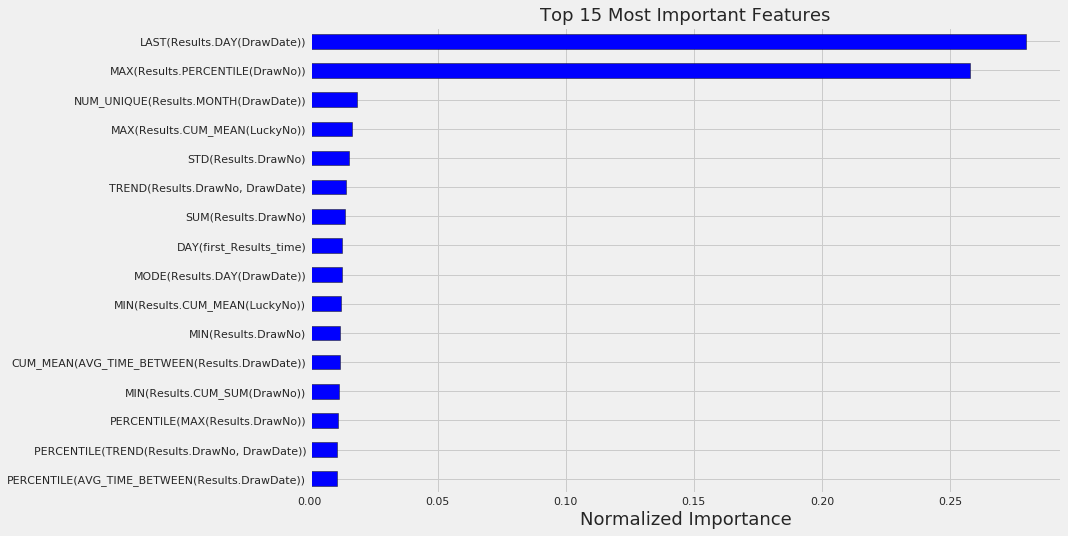

In [32]:
norm_june_2019_fi = plot_feature_importances(june_2019)

In [135]:
## Loop through from June to Dec
start_mt = pd.datetime(2019,6,1)
how_many_mt = 7
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")
  %time predict_dt(month_to_predict, feature_matrix_selection)

2019-06-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 649972
Size of X train 649972
Size of X test  10000
Training on 649972 observations.
Testing on 10000 observations.

Total predicted to be positive:  23
Precision: 1.0
Recall: 0.06845
F1 Score: 0.12813
ROC AUC: 0.53763
Accuracy: 0.9687
Average precision: 0.09975
Confusion matrix
[[9664    0]
 [ 313   23]]
Predicted matches
23 (array([  5,  17,  28,  59,  74,  76,  86,  97, 102, 105, 122, 125, 151,
       161, 164, 168, 201, 206, 242, 246, 283, 299, 314]),)
Matched draws
23 (array([  5,  17,  28,  59,  74,  76,  86,  97, 102, 105, 122, 125, 151,
       161, 164, 168, 201, 206, 242, 246, 283, 299, 314]),)


,DrawNo,DrawDate,PrizeType,LuckyNo
104558,495419,2019-06-01,1stPrizeNo,7882
104559,495419,2019-06-01,2ndPrizeNo,8550
104560,495419,2019-06-01,3rdPrizeNo,7022
104561,495419,2019-06-01,ConsolationNo1,2969
104562,495419,2019-06-01,ConsolationNo10,4336
104563,495419,2019-06-01,ConsolationNo2,2006
104564,495419,2019-06-01,ConsolationNo3,9275
104565,495419,2019-06-01,ConsolationNo4,2089
104566,495419,2019-06-01,ConsolationNo5,3649
104567,495419,2019-06-01,ConsolationNo6,2537


2019-07-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 659972
Size of X train 659972
Size of X test  10000
Training on 659972 observations.
Testing on 10000 observations.

Total predicted to be positive:  0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.50939
Accuracy: 0.9686
Average precision: 0.0314
Confusion matrix
[[9686    0]
 [ 314    0]]
Predicted matches
0 (array([], dtype=int64),)
No luck this month
2019-08-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 669972
Size of X train 669972
Size of X test  10000
Training on 669972 observations.
Testing on 10000 observations.

Total predicted to be positive:  0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.47624
Accuracy: 0.9686
Average precision: 0.0314
Confusion matrix
[[9686    0]
 [ 314    0]]
Predicted matches
0 (array([], dtype=int64),)
No luck this month
2019-09-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 679972
Size 

,DrawNo,DrawDate,PrizeType,LuckyNo
105547,499719,2019-09-01,1stPrizeNo,1574
105548,499719,2019-09-01,2ndPrizeNo,3192
105549,499719,2019-09-01,3rdPrizeNo,3926
105550,499719,2019-09-01,ConsolationNo1,8171
105551,499719,2019-09-01,ConsolationNo10,9001
105552,499719,2019-09-01,ConsolationNo2,1800
105553,499719,2019-09-01,ConsolationNo3,2731
105554,499719,2019-09-01,ConsolationNo4,5091
105555,499719,2019-09-01,ConsolationNo5,6780
105556,499719,2019-09-01,ConsolationNo6,3791


2019-10-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 689972
Size of X train 689972
Size of X test  10000
Training on 689972 observations.
Testing on 10000 observations.

Total predicted to be positive:  23
Precision: 1.0
Recall: 0.07256
F1 Score: 0.13529
ROC AUC: 0.54742
Accuracy: 0.9706
Average precision: 0.10196
Confusion matrix
[[9683    0]
 [ 294   23]]
Predicted matches
23 (array([ 23,  32,  43,  59,  61,  90, 103, 110, 145, 149, 154, 164, 166,
       189, 228, 233, 241, 255, 281, 300, 305, 308, 312]),)
Matched draws
23 (array([ 23,  32,  43,  59,  61,  90, 103, 110, 145, 149, 154, 164, 166,
       189, 228, 233, 241, 255, 281, 300, 305, 308, 312]),)


,DrawNo,DrawDate,PrizeType,LuckyNo
105869,501119,2019-10-01,1stPrizeNo,7344
105870,501119,2019-10-01,2ndPrizeNo,4600
105871,501119,2019-10-01,3rdPrizeNo,3162
105872,501119,2019-10-01,ConsolationNo1,9520
105873,501119,2019-10-01,ConsolationNo10,1836
105874,501119,2019-10-01,ConsolationNo2,4483
105875,501119,2019-10-01,ConsolationNo3,502
105876,501119,2019-10-01,ConsolationNo4,6958
105877,501119,2019-10-01,ConsolationNo5,9808
105878,501119,2019-10-01,ConsolationNo6,1069


2019-11-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 699972
Size of X train 699972
Size of X test  10000
Training on 699972 observations.
Testing on 10000 observations.

Total predicted to be positive:  0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.49021
Accuracy: 0.9692
Average precision: 0.0308
Confusion matrix
[[9692    0]
 [ 308    0]]
Predicted matches
0 (array([], dtype=int64),)
No luck this month
2019-12-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 709972
Size of X train 709972
Size of X test  10000
Training on 709972 observations.
Testing on 10000 observations.

Total predicted to be positive:  23
Precision: 1.0
Recall: 0.07278
F1 Score: 0.13569
ROC AUC: 0.54434
Accuracy: 0.9707
Average precision: 0.10208
Confusion matrix
[[9684    0]
 [ 293   23]]
Predicted matches
23 (array([  0,   7,  16,  42,  61,  84,  98, 101, 111, 121, 133, 135, 136,
       188, 195, 198, 221, 243, 246, 258, 263, 283, 303]),)
M

,DrawNo,DrawDate,PrizeType,LuckyNo
106513,503919,2019-12-01,1stPrizeNo,26
106514,503919,2019-12-01,2ndPrizeNo,3782
106515,503919,2019-12-01,3rdPrizeNo,5711
106516,503919,2019-12-01,ConsolationNo1,3098
106517,503919,2019-12-01,ConsolationNo10,8826
106518,503919,2019-12-01,ConsolationNo2,3791
106519,503919,2019-12-01,ConsolationNo3,7458
106520,503919,2019-12-01,ConsolationNo4,6075
106521,503919,2019-12-01,ConsolationNo5,3727
106522,503919,2019-12-01,ConsolationNo6,2438


In [ ]:
 # %time oct_2019 = predict_dt(pd.datetime(2019,10,1), feature_matrix_selection)

In [ ]:
#month_data = feature_matrix_selection.loc[feature_matrix_selection['time'] == pd.datetime(2019,6,1)]
# aa = np.sort(np.array([month_data.NumberId]))
# print(len(aa[0]),aa)
# print(np.array([month_data.NumberId]))
#month_data[month_data['Label'] == 1]['NumberId']

In [ ]:
#dd = pd.read_csv(DATASET_PATH/"feature_matrix_2.csv", header=0, sep=',', quotechar='"', parse_dates=['time'])
#prev_data = dd.loc[dd['time'] == pd.datetime(2019,6,1)]
#prev_data[prev_data['Label'] == 1]['NumberId']
#print(np.array([prev_data.NumberId]))

## Check Raw Data

In [ ]:
# number = [[128], [511]] 
# d = pd.DataFrame(number, columns = ['NumberId']) 
# d

In [ ]:
#display(origin_data[(origin_data['DrawDate'].dt.year == 2019) & (origin_data['DrawDate'].dt.month == 6) & (origin_data['LuckyNo'].isin(d.NumberId))].head(10))

In [ ]:
#display(origin_data[(origin_data['DrawDate'].dt.year == 2019) & (origin_data['DrawDate'].dt.month == 10)].head(30))

In [35]:
origin_data[(origin_data['DrawDate'].dt.year == 2019) & (origin_data['DrawDate'].dt.month == 6)]['DrawNo'].nunique()

15

In [36]:
origin_data[(origin_data['DrawDate'].dt.year == 2019) & (origin_data['DrawDate'].dt.month == 10)]['DrawNo'].nunique()

14

In [37]:
print(15 * 23 + 14 * 23)

667



## Parameter Tuning - GridSearchCV